In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from fractions import Fraction

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data source: https://www.kaggle.com/datasets/lantanacamara/hong-kong-horse-racing/data 

Feature definition: https://www.kaggle.com/datasets/lantanacamara/hong-kong-horse-racing/discussion/40574
- finishing_position: final position of the race (e.g. 3)
- horse_number: horse number (e.g. 10)
- horse_name: horse name (e.g. GOLDWEAVER)
- horse_id: unique horse id (e.g. P072)
- jockey: jockey name (e.g. Y T Cheng)
- trainer: trainer name (e.g. Y S Tsui)
- actual_weight: The total weight, in pounds, a runner carries during a race including jockey, saddle and extra metal weights. (e.g. 121)
- declared_horse_weight: horse weight in pounds (e.g. 1065)
- draw: The draw refers to a horse’s position in the starting gate. Draw number is randomly assigned by computer a couple of days before the race (e.g. 3)
- length_behind_winner: measurement in horse length between the winner and the running horse. A horse length is approximately 8 feet from nose to tail. (e.g. 2)
- running_position_1: Places during a race where the running positions are indicated in a track chart. (e.g. 2)
- running_position_2: Places during a race where the running positions are indicated in a track chart. (e.g. 1)
- running_position_3: Places during a race where the running positions are indicated in a track chart. (e.g. 1)
- running_position_4: Places during a race where the running positions are indicated in a track chart. (e.g. 3)
- finish_time: race finish time (e.g. 1.22.66)
- win_odds: winning odds and returns. For example win_odds = "3" means "1/3" or "33.3%" chance of winning and return is "3 x initial stake" (e.g. 5.7)
- running_position_5: Places during a race where the running positions are indicated in a track chart. (e.g. NA)
- running_position_6: Places during a race where the running positions are indicated in a track chart. (e.g. NA)
- race_id: race number (e.g. 2014-001)

Symbol Reference: https://racing.hkjc.com/racing/english/racing-info/special_race_index.asp
- DISQ: Disqualified - The horse was disqualified from the race due to a rule violation.
- DNF: Did Not Finish - The horse did not complete the race for some reason.
- FE: Horse fell during the race - Indicates that the horse fell during the race.
- ML: Many Lengths - Often used to describe the winning margin of a horse, indicating that it won by a significant number of lengths.
- PU: Pulled Up - The horse was withdrawn from the race by its jockey or stopped running before completing the race due to an issue.
- TNP: Took No Part - The horse was present at the start of the race but did not participate.
- TO: Tailed Off - The horse lagged far behind the rest of the field during the race.
- UR: Unseated Rider - The jockey fell off the horse during the race.
- VOID: Void Race - The race was declared void, often due to unforeseen circumstances or irregularities.
- WR: Withdrawn-by Starter - The horse was withdrawn from the race by the starter before the race began.
- WV: Withdrawn-on Veterinary Grounds - The horse was withdrawn from the race based on veterinary advice or grounds.
- WV-A: Withdrawn-on Veterinary Grounds after weighing out - The horse was withdrawn from the race based on veterinary advice after the weighing out process.
- WX: Withdrawn-by order of Stewards - The horse was withdrawn from the race by order of the stewards.
- WX-A: Withdrawn-by order of Stewards after weighing out - The horse was withdrawn from the race by order of the stewards after the weighing out process.
- WXNR: Withdrawn-non runner - The horse was withdrawn from the race as a non-runner, often due to injury or other reasons.

Reference for data exploration: https://www.kaggle.com/code/alberthkcheng/hong-kong-horse-racing-explained-with-data/notebook (Note that this reference uses outdated data)

# Data Cleaning and Exploration 

ADD IN MEAN, MEDIAN, DRAWDOWN. Add graph for drawdown

In [2]:
# import data
race_result_horse = pd.read_csv("./data/race-result-horse.csv")

In [3]:
race_result_horse.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,1.0,2.0,2.0,1.0,1.22.33,3.8,NaN,NaN,2014-001
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,8.0,9.0,9.0,2.0,1.22.65,8,NaN,NaN,2014-001
2,3,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121,1065,3,2,2.0,1.0,1.0,3.0,1.22.66,5.7,NaN,NaN,2014-001
3,4,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132,1222,2,2,6.0,4.0,5.0,4.0,1.22.66,6.1,NaN,NaN,2014-001
4,5,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125,1136,9,4-1/4,9.0,10.0,10.0,5.0,1.23.02,6.1,NaN,NaN,2014-001


## Single Bet Strategies (Benchmark):

- Betting on Favourite: Place bet on horse with worst bet odds (Highest chance of winning)
- Betting on Long Shot: Place bet on horse with best bet odds (Lowest chance of winning)


In [4]:
race_result_horse.dropna(subset=['win_odds'], inplace=True)
race_result_horse['win_odds'] = pd.to_numeric(race_result_horse['win_odds'], errors='coerce')
race_result_horse = race_result_horse.dropna(subset=['win_odds'])
race_result_horse['winning_chance'] = 1 / race_result_horse['win_odds']


Convert all 1 DH (Multiple winners) to 1 for finishing_position column

In [5]:
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].astype(str)
race_result_horse['finishing_position'] = race_result_horse['finishing_position'].replace('1 DH', '1')

Betting on Favourite: If horse has lowest win_odds bet weight of 1 given, otherwise 0. For cases where multiple horses share the spot of most likely to win, normalise the bet weights so that it never is greater than 1. Create a column called result where winner is 1 and the rest is -1. Returns for winner is normalised bet weight * result * win_odds, for loser it is negative normalised bet weight

In [6]:
favourite_strategy = race_result_horse
favourite_strategy['min_win_odds'] = favourite_strategy.groupby('race_id')['win_odds'].transform('min')
favourite_strategy['bet_weight'] = (favourite_strategy['win_odds'] == favourite_strategy['min_win_odds']).astype(int)

sum_bet_weights_per_race = favourite_strategy.groupby('race_id')['bet_weight'].transform('sum')
favourite_strategy['normalized_bet_weight'] = favourite_strategy['bet_weight'] / sum_bet_weights_per_race

favourite_strategy['finishing_position'] = favourite_strategy['finishing_position'].astype(str)
favourite_strategy['result'] = np.where(favourite_strategy['finishing_position'].isin(['1']), 1, -1)

favourite_strategy['returns'] = np.where(
    favourite_strategy['result'] == 1, 
    favourite_strategy['normalized_bet_weight'] * favourite_strategy['result'] * favourite_strategy['win_odds']-favourite_strategy['normalized_bet_weight'], 
    -favourite_strategy['normalized_bet_weight'])

In [7]:
favourite_strategy['race returns'] = favourite_strategy.groupby('race_id')['returns'].transform('sum')
favourite_strategy_race_returns = favourite_strategy.groupby('race_id')['race returns'].first().reset_index()
fav_mean_value = favourite_strategy_race_returns['race returns'].mean()
fav_max_value = favourite_strategy_race_returns['race returns'].max()
fav_median_value = favourite_strategy_race_returns['race returns'].median()
fav_min_value = favourite_strategy_race_returns['race returns'].min()

print("Favourite Strategy Mean Race PnL:", fav_mean_value)
print("Favourite Strategy Max Race PnL:", fav_max_value)
print("Favourite Strategy Median Race PnL:", fav_median_value)
print("Favourite Strategy Min Race PnL:", fav_min_value)




Favourite Strategy Mean Race PnL: -0.13677651035065483
Favourite Strategy Max Race PnL: 4.4
Favourite Strategy Median Race PnL: -1.0
Favourite Strategy Min Race PnL: -1.0


Betting on Favourite Wealth Curve (Assume a bet on 100 per race, starting with 100 for first race)

In [8]:
favourite_strategy_race_returns['wealth'] = (favourite_strategy_race_returns['race returns']  * 100)
favourite_strategy_race_returns['cumulative_wealth'] = favourite_strategy_race_returns['wealth'].cumsum()

print("Lowest Account Value : " + str(favourite_strategy_race_returns['cumulative_wealth'].min()))
print("Final Account Value : " + str(favourite_strategy_race_returns['wealth'].sum()))

subset_df_ten = favourite_strategy_race_returns.head(10)
subset_df_fifty = favourite_strategy_race_returns.head(50)
subset_df_hundred = favourite_strategy_race_returns.head(100)
subset_df_five_hundred = favourite_strategy_race_returns.head(500)
subset_df_thousand = favourite_strategy_race_returns.head(1000)

print("10 Race Returns : " + str(subset_df_ten['wealth'].sum()))
print("50 Race Returns : " + str(subset_df_fifty['wealth'].sum()))
print("100 Race Returns : " + str(subset_df_hundred['wealth'].sum()))
print("500 Race Returns : " + str(subset_df_five_hundred['wealth'].sum()))
print("1000 Race Returns : " + str(subset_df_thousand['wealth'].sum()))



Lowest Account Value : -32425.0
Final Account Value : -32375.0
10 Race Returns : -230.0
50 Race Returns : -1830.0
100 Race Returns : -45.0
500 Race Returns : -5495.0
1000 Race Returns : -12240.0


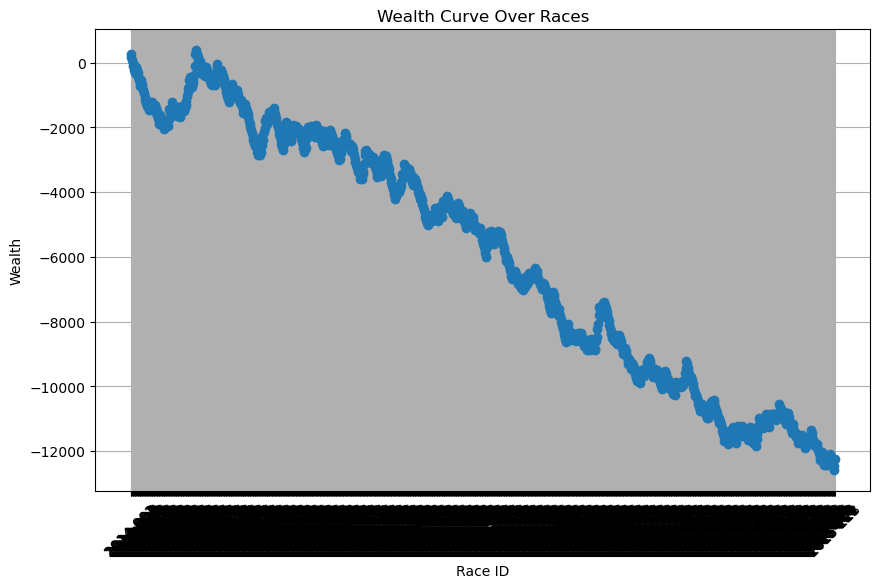

In [9]:
subset_df = favourite_strategy_race_returns.head(1000)
plt.figure(figsize=(10, 6))
plt.plot(subset_df['race_id'], subset_df['cumulative_wealth'], marker='o', linestyle='-')
plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Wealth')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

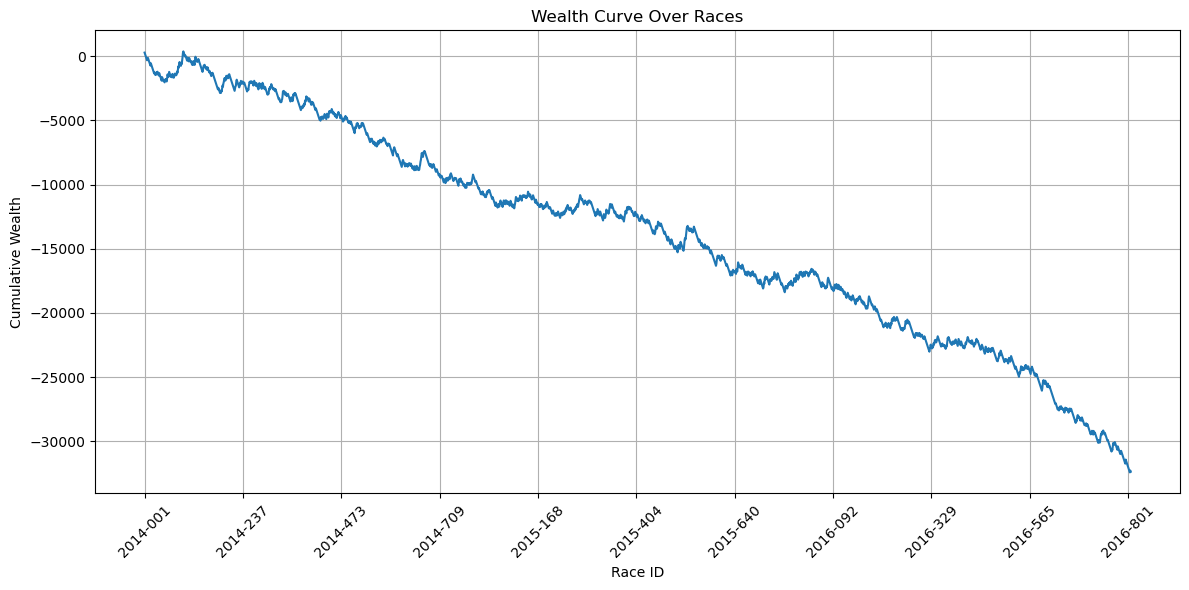

In [10]:
subset_df = favourite_strategy_race_returns.head(30000)

# Assuming 'subset_df' is your DataFrame after selecting the top 1000 entries
plt.figure(figsize=(12, 6))  # Increase figure size for clarity

# Plot without markers for a clearer view of the trend
plt.plot(subset_df['race_id'], subset_df['cumulative_wealth'], linestyle='-')

plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Cumulative Wealth')

# To avoid label overlap on the x-axis, selectively display x-axis labels
n = len(subset_df['race_id']) // 10  # Adjust the denominator as needed for optimal spacing
plt.xticks(subset_df['race_id'][::n], rotation=45)

plt.grid(True)
plt.tight_layout()  # Adjust the layout to accommodate rotated x-axis labels
plt.show()

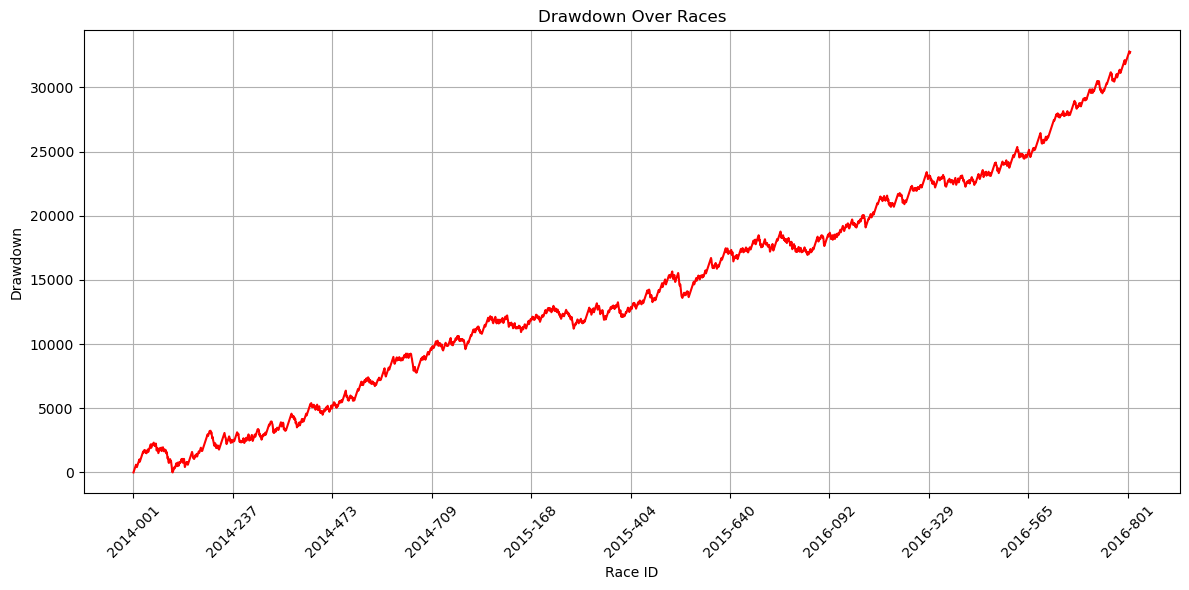

In [11]:
# Calculate the cumulative maximum wealth up to each point
subset_df['Cumulative_Max_Wealth'] = subset_df['cumulative_wealth'].cummax()

# Calculate drawdown as the difference between the current wealth and the cumulative max wealth
subset_df['Drawdown'] = subset_df['Cumulative_Max_Wealth'] - subset_df['cumulative_wealth']


plt.figure(figsize=(12, 6))
plt.plot(subset_df['race_id'], subset_df['Drawdown'], linestyle='-', color='red')

plt.title('Drawdown Over Races')
plt.xlabel('Race ID')
plt.ylabel('Drawdown')

# Adjust the x-axis labels similarly to your wealth curve plot for consistency
n = len(subset_df['race_id']) // 10
plt.xticks(subset_df['race_id'][::n], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion: betting on the favourite provides a small edge with an average profitability of 17.35%. This strategy is profitable in the long run (~100 races). Given that each race the bettor is risking their entire bet size, this strategy is best employed with a consistent bet size per race.

Long Shot Strategy (Similar to Favourite but inverse)

In [12]:
longshot_strategy = race_result_horse
longshot_strategy['min_win_odds'] = longshot_strategy.groupby('race_id')['win_odds'].transform('max')
longshot_strategy['bet_weight'] = (longshot_strategy['win_odds'] == longshot_strategy['min_win_odds']).astype(int)

sum_bet_weights_LS = longshot_strategy.groupby('race_id')['bet_weight'].transform('sum')
longshot_strategy['normalized_bet_weight'] = longshot_strategy['bet_weight'] / sum_bet_weights_LS

longshot_strategy['finishing_position'] = longshot_strategy['finishing_position'].astype(str)
longshot_strategy['result'] = np.where(longshot_strategy['finishing_position'].isin(['1']), 1, -1)

longshot_strategy['returns'] = np.where(
    longshot_strategy['result'] == 1, 
    longshot_strategy['normalized_bet_weight'] * longshot_strategy['result'] * longshot_strategy['win_odds']-longshot_strategy['normalized_bet_weight'], 
    -longshot_strategy['normalized_bet_weight'])

In [13]:
longshot_strategy['race returns'] = longshot_strategy.groupby('race_id')['returns'].transform('sum')
longshot_strategy_race_returns = longshot_strategy.groupby('race_id')['race returns'].first().reset_index()
LS_mean_value = longshot_strategy_race_returns['race returns'].mean()
LS_max_value = longshot_strategy_race_returns['race returns'].max()
LS_median_value = longshot_strategy_race_returns['race returns'].median()
LS_min_value = longshot_strategy_race_returns['race returns'].min()

print("Long Shot Strategy Mean Race PnL:", LS_mean_value)
print("Long Shot Strategy Max Race PnL:", LS_max_value)
print("Long Shot Strategy Median Race PnL:", LS_median_value)
print("Long Shot Strategy Min Race PnL:", LS_min_value)

Long Shot Strategy Mean Race PnL: -0.614702154626109
Long Shot Strategy Max Race PnL: 98.0
Long Shot Strategy Median Race PnL: -1.0
Long Shot Strategy Min Race PnL: -1.0


Wealth curve as above with bet of 100 per race

In [14]:
longshot_strategy_race_returns['wealth'] = longshot_strategy_race_returns['race returns']  * 100
longshot_strategy_race_returns['cumulative_wealth'] = longshot_strategy_race_returns['wealth'].cumsum()

print("Lowest Account Value : " + str(longshot_strategy_race_returns['cumulative_wealth'].min()))
print("Final Account Value : " + str(longshot_strategy_race_returns['wealth'].sum()))

subset_df_ten = longshot_strategy_race_returns.head(10)
subset_df_fifty = longshot_strategy_race_returns.head(50)
subset_df_hundred = longshot_strategy_race_returns.head(100)
subset_df_five_hundred = longshot_strategy_race_returns.head(500)
subset_df_thousand = longshot_strategy_race_returns.head(1000)

print("10 Race Returns : " + str(subset_df_ten['wealth'].sum()))
print("50 Race Returns : " + str(subset_df_fifty['wealth'].sum()))
print("100 Race Returns : " + str(subset_df_hundred['wealth'].sum()))
print("500 Race Returns : " + str(subset_df_five_hundred['wealth'].sum()))
print("1000 Race Returns : " + str(subset_df_thousand['wealth'].sum()))

Lowest Account Value : -149050.0
Final Account Value : -145500.0
10 Race Returns : -1000.0
50 Race Returns : -5000.0
100 Race Returns : -10000.0
500 Race Returns : -37200.0
1000 Race Returns : -69450.0


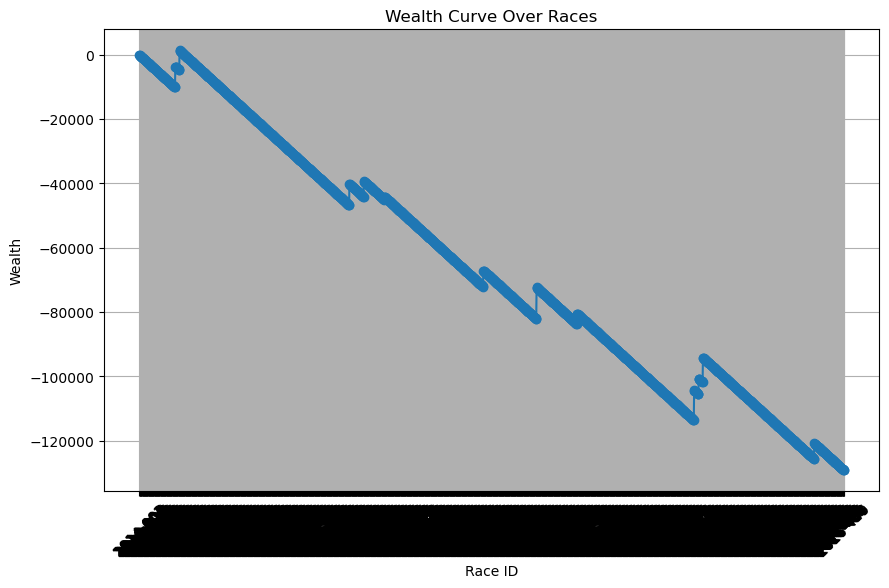

In [15]:
subset_df = longshot_strategy_race_returns.head(2000)
plt.figure(figsize=(10, 6))
plt.plot(subset_df['race_id'], subset_df['cumulative_wealth'], marker='o', linestyle='-')
plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Wealth')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

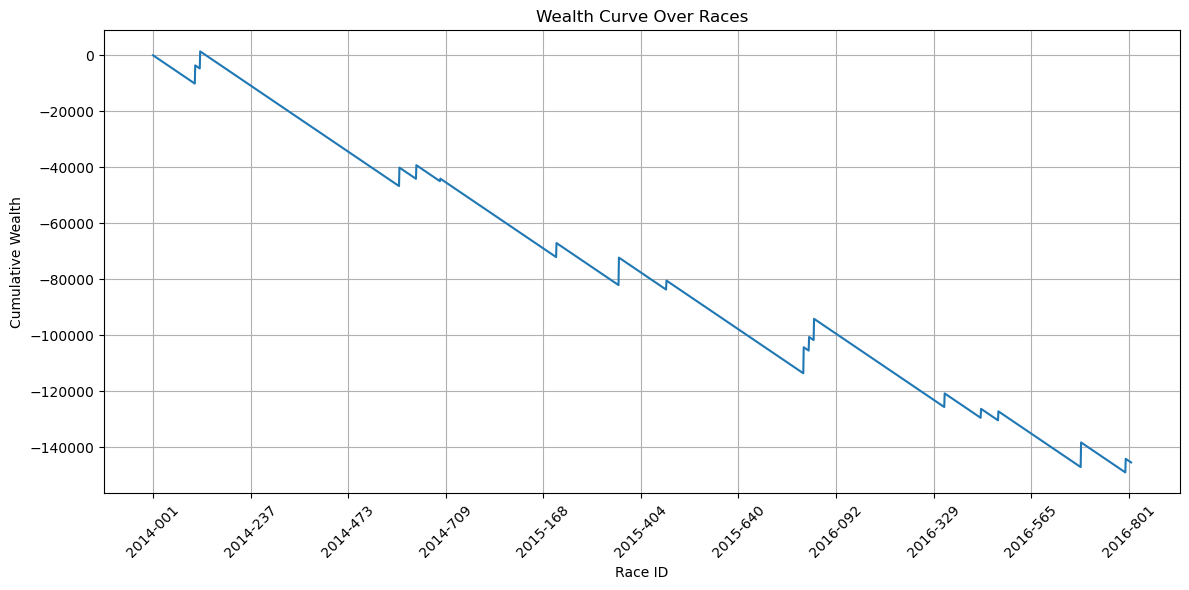

In [16]:
subset_df = longshot_strategy_race_returns.head(3000)

# Assuming 'subset_df' is your DataFrame after selecting the top 1000 entries
plt.figure(figsize=(12, 6))  # Increase figure size for clarity

# Plot without markers for a clearer view of the trend
plt.plot(subset_df['race_id'], subset_df['cumulative_wealth'], linestyle='-')

plt.title('Wealth Curve Over Races')
plt.xlabel('Race ID')
plt.ylabel('Cumulative Wealth')

# To avoid label overlap on the x-axis, selectively display x-axis labels
n = len(subset_df['race_id']) // 10  # Adjust the denominator as needed for optimal spacing
plt.xticks(subset_df['race_id'][::n], rotation=45)

plt.grid(True)
plt.tight_layout()  # Adjust the layout to accommodate rotated x-axis labels
plt.show()


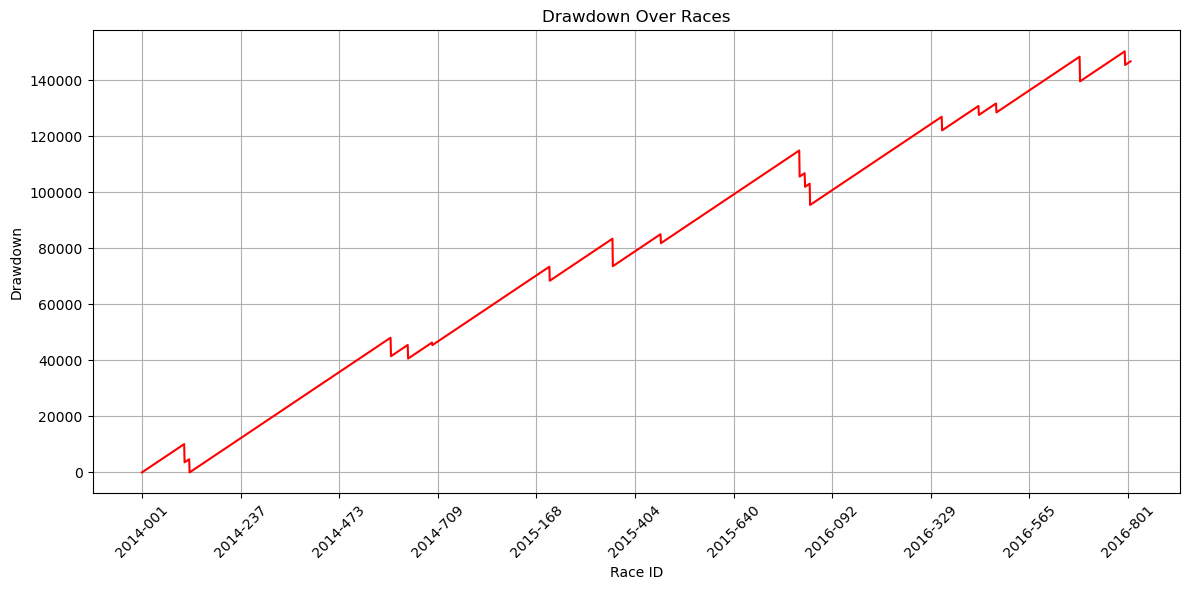

In [17]:
# Calculate the cumulative maximum wealth up to each point
subset_df['Cumulative_Max_Wealth'] = subset_df['cumulative_wealth'].cummax()

# Calculate drawdown as the difference between the current wealth and the cumulative max wealth
subset_df['Drawdown'] = subset_df['Cumulative_Max_Wealth'] - subset_df['cumulative_wealth']


plt.figure(figsize=(12, 6))
plt.plot(subset_df['race_id'], subset_df['Drawdown'], linestyle='-', color='red')

plt.title('Drawdown Over Races')
plt.xlabel('Race ID')
plt.ylabel('Drawdown')

# Adjust the x-axis labels similarly to your wealth curve plot for consistency
n = len(subset_df['race_id']) // 10
plt.xticks(subset_df['race_id'][::n], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion: Betting on long shot has the potential for very high returns (max 99x) but the odds of winning are incredibly low, with a mean of -60.98%. This makes the long shot bet a highly unprofitable strategy

In [ ]:
def print_stats(profit,cost, scale = 365):
    pnl = profit/cost
    mean = pnl.mean()
    std = pnl.std()
    median = pnl.median()
    cumsum_pnl = profit.cumsum()
    # append 0 to start of cumsum_pnl
    # cumsum_pnl = pd.concat([pd.Series([0]), cumsum_pnl], ignore_index=True)
    drawdown = (cumsum_pnl - cumsum_pnl.cummax())
    max_drawdown = min(drawdown.min(),cumsum_pnl.min())
    sharpe_ratio = mean / std * np.sqrt(scale)
    win_rate = (pnl > 0).sum() / (pnl != 0).sum()

    total_bets =  ((profit != 0)*cost).sum() 
    total_pct_return = cumsum_pnl[-1]/total_bets

    print("Win Rate:", round(win_rate*100,2), "%")
    print("Total Bets:", round(total_bets,2))
    print("Total Return:", round(cumsum_pnl[-1],2))
    print("Total Pct Return:", round(total_pct_return*100,2), "%")
    print("Mean: ", round(mean*100,2),"%")
    print("Standard Deviation: ", round(std*100,2),"%")
    print("Median: ", round(median*100,2),"%")
    print("Max Drawdown: ", round(max_drawdown,2))
    print("Sharpe Ratio: ", round(sharpe_ratio,4))
    

In [ ]:
# pnl each bet, what is the profit/loss
# cost is just amount bet
print_stats(pnl, cost, scale = 1)